## **Imports**

In [43]:
#import Pkg; Pkg.add("StatsPlots")

In [1]:
using Gen, Distributions, Base64, JSON, Luxor, Plots, GLM, JLD#, PyCall
import StatsPlots, Serialization

# sklearn_metrics = pyimport("sklearn.metrics")
# sklearn_linear_model = pyimport("sklearn.linear_model")

include("./src/inverse-planning/geometric_primitives.jl");
include("./src/inverse-planning/scene.jl");
include("./src/inverse-planning/viz.jl");
include("./src/inverse-planning/planning.jl");
include("./src/utils.jl");
include("./src/read_data.jl");
include("./src/agents/simple_agent_1.jl");

repo_path = readdata_get_gen_quickstart_repo_path()

"M:\\MyFiles\\Classes\\Grad\\Cognitive Science Project\\gen\\gen-quickstart"

In [2]:
function get_scene_trajectory(roomnum, tasknum, runno)
    
    label_key = string(tasknum)*"_"*string(runno)
    x = tasknum <= 40 ? "2" : "4"
    y = string((tasknum-1) % 40 + 1)
    file_name = "memory_"*x*".1."*y*".json"
    room = readdata_get_comm_game_path() * "/python_scripts/visualize/pairs_data/room0000"*roomnum
    dict1 = readdata_get_task_from_room(room, file_name, VERBOSE=false);
    
    playerdata1 = readdata_get_playerdata_from_task(dict1, 2*runno - 1, VERBOSE=false);
    playerdata2 = readdata_get_playerdata_from_task(dict1, 2*runno, VERBOSE=false);
    scene = utils_scene_from_playerdata(playerdata1, VERBOSE=false)
    
    if playerdata1["role"] == "STUDENT"  # Make player1 always teacher
        playerdata1, playerdata2 = playerdata2, playerdata1
    end
    player_trajectory1 = [Point(x, y) for (x, y) in zip(playerdata1["x"], playerdata1["y"])]
    player_trajectory2 = [Point(x, y) for (x, y) in zip(playerdata2["x"], playerdata2["y"])]
    
    trajectory = utils_strip_trajectory(player_trajectory1; epsilon=20)
    
    return scene, trajectory
    
end;

## **Load data**

room: 82
pair: 75-76
Getting file:memory_2.1.3.json
Json length:10 | #Runs should be (n-2)/2 = 4.0
scene size: 450 450
--- Map | Level: 1 Dist: teach
        | Fol: forall object is_big(object) then touch(object)
        | NatLang: Touch all objects that are big.
---------
--- Role: TEACHER | Done:true
--- Feedback: My partner did super well ! They were able to understand and execute it with only one teaching lesson. I think these instructions were less confusing for the both of us to teach and understand.
--- New signs count 0
--- Old sign keys: String[]
---------
--- Role: STUDENT | Done:true
--- Feedback: Just using map. Nothing confusing, Good job, Not that I can think of
Guess: Again it was a simple one
--- New signs count 0
--- Old sign keys: String[]
---------


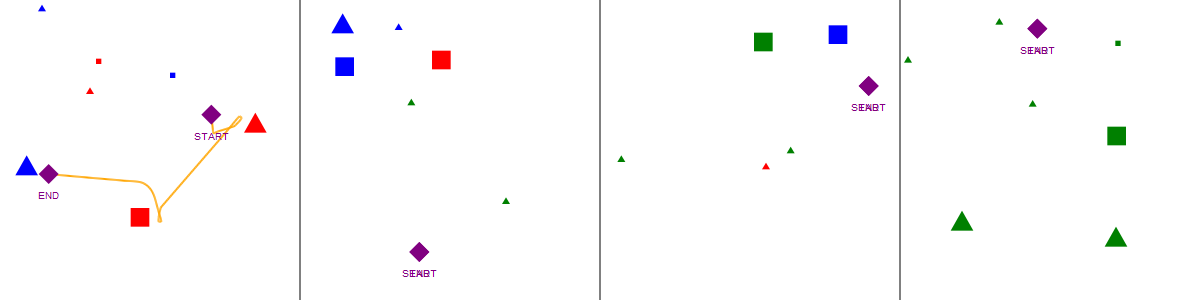

In [3]:
tasknum   = 3
roomnum   = "82"
all_rooms = ["58", "59", "61", "68", "69", "70", "71", "72", "76", "79", "81", "82", "83"];

readdata_visualize_memory(roomnum=roomnum, tasknum=tasknum; hide_student=true)

In [4]:
training_labels   = Serialization.deserialize("data/0_labels_6")
validation_labels = Serialization.deserialize("data/0_labels_7")

for room in keys(validation_labels)
    for data in keys(validation_labels[room])
        if data in keys(training_labels[room]) # in training
            delete!(validation_labels[room], data)
        end
    end
end

# PRINTING
for room in keys(validation_labels)
    for data in keys(validation_labels[room])
        if length(validation_labels[room][data]) > 0
            println("P: ", room, ", ", data)
        else
            println("N: ", room, ", ", data)
        end
    end
end

# DOUBLE CHECK
for room in keys(validation_labels)
    for data in keys(validation_labels[room])
        if data in keys(training_labels[room]) # in training
            println("SHOULD NOT HAPPEN")
        end
    end
end

N: 81, 8_1
N: 81, 31_11
N: 81, 2_7
N: 81, 13_1
N: 81, 2_5
P: 81, 25_6
N: 81, 9_1
N: 81, 1_1
N: 81, 7_1
N: 81, 10_1
N: 81, 1_3
N: 81, 2_1
N: 81, 11_1
N: 81, 12_1
P: 79, 33_1
P: 79, 13_1
P: 79, 22_3
P: 79, 36_1
P: 79, 8_1
P: 76, 16_1
N: 76, 19_5
P: 76, 11_2
N: 76, 13_1
N: 76, 15_7
N: 76, 24_1
P: 76, 11_10
N: 76, 26_1
N: 76, 28_1
P: 76, 26_10
N: 76, 28_3
P: 76, 11_5
P: 76, 11_13
N: 76, 19_1
N: 76, 14_1
P: 76, 12_1
N: 76, 28_6
N: 76, 17_4
N: 76, 15_4
P: 76, 16_3
P: 76, 10_11
N: 76, 26_3
P: 76, 11_16
P: 76, 11_7
P: 76, 10_3
N: 76, 15_1
N: 76, 17_1
P: 76, 4_7
N: 76, 26_12
P: 76, 21_9
P: 76, 18_7
N: 76, 19_10
N: 76, 26_6


## **Generative Model**

In [447]:
scene, trajectory = get_scene_trajectory("83", 5, 1)

num_ticks      = 3;
dt             = 1/(num_ticks);
planner_params = PlannerParams(rrt_iters=200, rrt_dt=10.0, refine_iters=1000, refine_std=5.);
agent_args     = simpleagent1_make_args(scene, dt, num_ticks, planner_params; noise=3.0, angle_beta=1.0, 
                                        pre_comp_rrt=nothing, obstacle_outlier=0.10);

constraints = Gen.choicemap();
constraints[:start_x] = 1;
constraints[:start_y] = 200;
#constraints[:dest_shape] = 4;
constraints[:speed] = 75;

traces = [Gen.generate(simpleagent1_model, (agent_args, ), constraints)[1] for i in 1:12];

visualize_grid(traces, 4, 800; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true, markersize=6)
end

LoadError: UndefVarError: get_scene_trajectory not defined

## **Inference**

In [5]:
function run_model(scene, trajectory)
    
    # Agent parameters
    num_ticks       = 3;
    dt              = 1/num_ticks;
    planner_params  = PlannerParams(rrt_iters=200, rrt_dt=10.0, refine_iters=1000, refine_std=5.);
    #agent_args      = simpleagent1_make_args(scene, dt, num_ticks, planner_params; noise=3.0, angle_beta=2.0, pre_comp_rrt=nothing);
    samples         = 30;
    computation_amt = 100;
    
    # Lists for results
    path_complexity = zeros(length(trajectory)-(num_ticks-1), 1);
    target_distribution = zeros(length(trajectory)-(num_ticks-1), length(scene.obstacles));
    target_mean_distance = zeros(length(trajectory)-(num_ticks-1), 1);
    trace_score = zeros(length(trajectory)-(num_ticks-1), 1);
    
    fill!(target_mean_distance, 1000)
    fill!(trace_score, -1000)
    
    # 
    pre_comp_rrt_vector = [[generate_rrt(scene, start, planner_params.rrt_iters, planner_params.rrt_dt) for _ in 1:50] for start in trajectory]
    
    counter_fail = nothing
    counter_outlier = nothing
    
    for i = 1:length(trajectory)-(num_ticks-1)
        
        measuremene = trajectory[i:i+num_ticks-1]
        path_complexity[i,1] = 1 - path_linearity(measuremene)
        
        agent_args = simpleagent1_make_args(scene, dt, num_ticks, planner_params; 
                                            noise=3.0, angle_beta=2.0, pre_comp_rrt=pre_comp_rrt_vector[i],
                                            obstacle_outlier=0.10)
        
        # Counters if planning failed
        counter_fail = 0
        counter_outlier = 0;
        
        for j in 1:samples
            
            trace = do_inference(agent_args, measuremene[1], measuremene, computation_amt)
            planning_failed = Gen.get_retval(trace)[:planning_failed]
            
            if planning_failed
                counter_fail += 1;
                continue
            end
            
            if trace[:obstacle_outlier]
                counter_outlier += 1;
                continue
            end
            trace_score[i, 1] += get_score(trace)
            target_distribution[i, trace[:dest_shape]] += 1
            target_mean_distance[i, 1] += euclidean_distance_obstacle_point(scene.obstacles[trace[:dest_shape]], 
                                                                            measuremene[end][1],
                                                                            measuremene[end][2])
        end;
        
        if (samples-counter_fail-counter_outlier) != 0
            trace_score[i, 1] = trace_score[i, 1]/(samples-counter_fail-counter_outlier)
            target_distribution[i, :] = target_distribution[i, :]/(samples-counter_fail-counter_outlier)
            target_mean_distance[i, 1] = target_mean_distance[i, 1]/(samples-counter_fail-counter_outlier)
        end
        
    end;
    
    results = Dict("target_distribution" => target_distribution, 
                   "target_mean_distance" => target_mean_distance,
                   "trace_score" => trace_score,
                   "path_complexity" => path_complexity,
                   "planning_failed" => (counter_fail)/(samples),
                   "planning_outlier" => (counter_outlier)/(samples),)
    
    return results
    
end;

function do_inference(agent_args::Dict, start::Point, 
                      measurements::Vector{Point}, 
                      amount_of_computation::Int)

    # Constrain the observed measurements
    observations = Gen.choicemap()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end

    (trace, _) = importance_resampling(simpleagent1_model, (agent_args, ), observations, amount_of_computation)

    return trace
end;


function block_resimulation_update(trace)
    
    (trace,b3) = mh(trace, Gen.select(:dest_shape))

    for i=1:10
        (trace,b1) = mh(trace, Gen.select(:dest_angle))
        (trace,b2) = mh(trace, Gen.select(:speed)) 
    end

    return trace
    
end;


function do_inference_mh(agent_args::Dict, start::Point, 
                         measurements::Vector{Point},
                         amount_of_computation::Int)
    
    amount_of_computation = Integer(amount_of_computation/20)
    
    # Constrain the observed measurements.
    observations = Gen.choicemap()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end

    (trace, _) = Gen.generate(simpleagent1_model, (agent_args,), observations)

    for iter=1:amount_of_computation
        trace = block_resimulation_update(trace)
    end

    return trace;
    
end;

function euclidean_distance(p1::Point, p2::Point)
    l2 = sqrt((p1.x - p2.x)^2 + (p1.y - p2.y)^2)
    return l2
end;

function euclidean_distance_obstacle_point(obstacle, x, y)
    
    xs = [i.x for i in obstacle.vertices]
    ys = [i.y for i in obstacle.vertices]
    midx, midy = sum(xs)/length(xs), sum(ys)/length(ys)
    dist = sqrt((x-midx)^2 + (y-midy)^2)
    
    return dist
end;

function path_length(path::Array{Point, 1}, closed=false)
    l = 0.0
    for i in 1:length(path) - 1
        l += euclidean_distance(path[i], path[i+1])
    end
    if closed
        l += euclidean_distance(path[end], path[1])
    end
    return l
end;

function path_linearity(path::Array{Point, 1})
    # println(length(path))
    # p = copy(path)
    # p = p[end-min(5, length(p)-1):end]
    # println(length(p))
    # println(length(path))
    println()
    len  = path_length(path)
    path = path ./ len
    xc = sum([i.x for i in path])/length(path)
    yc = sum([i.y for i in path])/length(path)
    centroid = Point(xc, yc)
    linearity = euclidean_distance(path[1], centroid) + euclidean_distance(path[end], centroid)
    linearity = clamp.(linearity, 0, Inf)
    return linearity
end;

function labels_to_array(array::Array{Int64,1}, max::Int64)
    result = []
    for i = 1:max
        if i in array
            push!(result, 1)
        else
            push!(result, 0)
        end
    end
    return result
end;

function get_window_min(m; window_half_len = 2)
    m_min = zeros(size(m))
    for j in 1:size(m, 2)
        for i in 1:size(m, 1)
            window = (i-window_half_len, i+window_half_len)
            # window = (i-window_half_len, i)
            window = (max(window[1], 1), min(window[2], size(m, 1)))
            window_elem = m[window[1]:window[2], j]
            if any([isnothing(i) for i in window_elem])
                window_elem = [i for i in window_elem if !isnothing(i)]  # remove nothing
                println(i, " ", j)
            end
            m_min[i, j] = length(window_elem)>0 ? minimum(window_elem) : 0
            # m_min[i, j] = minimum(window_elem)
        end
    end
    return m_min
end;

function get_window_max(m; window_half_len = 2)
    m_min = zeros(size(m))
    for j in 1:size(m, 2)
        for i in 1:size(m, 1)
            window = (i-window_half_len, i+window_half_len)
            # window = (i-window_half_len, i)
            window = (max(window[1], 1), min(window[2], size(m, 1)))
            window_elem = m[window[1]:window[2], j]
            if any([isnothing(i) for i in window_elem])
                window_elem = [i for i in window_elem if !isnothing(i)]  # remove nothing
                println(i, " ", j)
            end
            m_min[i, j] = length(window_elem)>0 ? maximum(window_elem) : 0
            # m_min[i, j] = minimum(window_elem)
        end
    end
    return m_min
end;

function get_window_mean(m; window_half_len = 2)
    m_min = zeros(size(m))
    for j in 1:size(m, 2)
        for i in 1:size(m, 1)
            window = (i-window_half_len, i+window_half_len)
            # window = (i-window_half_len, i)
            window = (max(window[1], 1), min(window[2], size(m, 1)))
            window_elem = m[window[1]:window[2], j]
            if any([isnothing(i) for i in window_elem])
                window_elem = [i for i in window_elem if !isnothing(i)]  # remove nothing
                println(i, " ", j)
            end
            m_min[i, j] = length(window_elem)>0 ? mean(window_elem) : 0
            # m_min[i, j] = minimum(window_elem)
        end
    end
    return m_min
end;

function get_window_var(m; window_half_len = 2)
    m_min = zeros(size(m))
    for j in 1:size(m, 2)
        for i in 1:size(m, 1)
            window = (i-window_half_len, i+window_half_len)
            # window = (i-window_half_len, i)
            window = (max(window[1], 1), min(window[2], size(m, 1)))
            window_elem = m[window[1]:window[2], j]
            if any([isnothing(i) for i in window_elem])
                window_elem = [i for i in window_elem if !isnothing(i)]  # remove nothing
                println(i, " ", j)
            end
            m_min[i, j] = length(window_elem)>0 ? moment(window_elem, 3) : 0
            # m_min[i, j] = m_min[i, j]>10 ? 10 : m_min[i, j]
            # m_min[i, j] = isnan(m_min[i, j]) ? 0 : m_min[i, j]
            # m_min[i, j] = isnothing(m_min[i, j]) ? 0 : m_min[i, j]
            # m_min[i, j] = minimum(window_elem)
        end
    end
    return m_min
end;
function my_variance(x)
    n = length(x)
    μ = sum(x) / n
    sum((x .- μ) .^ 1) / (n - 1)
end

function total_variation_distance(target_distribution)
    
    diff = target_distribution[1:size(target_distribution)[1]-1,:] - target_distribution[2:end,:]
    total_variation = abs.(diff)
    total_variation = sum(total_variation, dims=2)/2
    total_variation = vcat(total_variation, [0])
    
    return total_variation
    
end;

function run_model_rooms_labels(rooms, labels)
    
    results_list = Dict()
    labels_list  = Dict()

    for room in rooms
        
        results_list[room] = Dict()
        labels_list[room]  = Dict()

        for data in labels[room]

            # Get scene and trajectory
            tasknum = parse(Int64, split(data[1], "_")[1])
            runno = parse(Int64, split(data[1], "_")[2])
            label = data[2]
            scene, trajectory = get_scene_trajectory(room, tasknum, runno);

            display(data[1])

            # Run model
            results = run_model(scene, trajectory);
            results_len = length(results["trace_score"])

            # Store results
            results_list[room][data[1]] = results;

            if length(label) == 0
                labels_list[room][data[1]] = labels_to_array([0], results_len);
            else
                labels_list[room][data[1]] = labels_to_array(label, results_len);
            end;
            return nothing
        end;

    end;
    
    return results_list, labels_list
    
end;

In [449]:
moment([1], 3)

0.0

In [14]:
import JLD

training_rooms = ["58","69","70","83"];

# training_results_list, training_labels_list = run_model_rooms_labels(training_rooms, training_labels);

loaded = JLD.load("results/0_results_6.jld")
training_results_list = loaded["results_list"]
training_labels_list = loaded["labels_list"]
#save("0_results_5.jld", "results_list", results_list, "labels_list", labels_list)


Dict{Any, Any} with 4 entries:
  "58" => Dict{Any, Any}("1_1"=>Any[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0…
  "83" => Dict{Any, Any}("14_6"=>Any[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, …
  "70" => Dict{Any, Any}("8_9"=>Any[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 0, 0, 0…
  "69" => Dict{Any, Any}("9_1"=>Any[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…

In [15]:
validation_rooms = ["76","79","81"];

# validation_results_list, validation_labels_list = run_model_rooms_labels(validation_rooms, validation_labels);

loaded = JLD.load("results/0_results_7.jld")
validation_results_list = loaded["results_list"]
validation_labels_list = loaded["labels_list"]
#save("0_results_6.jld", "results_list", validation_results_list, "labels_list", validation_labels_list)

Dict{Any, Any} with 3 entries:
  "81" => Dict{Any, Any}("8_1"=>Any[0, 0, 0, 0, 0, 0, 0], "31_11"=>Any[0, 0, 0,…
  "79" => Dict{Any, Any}("33_1"=>Any[0, 0, 0, 0, 0, 0, 0, 1, 1, 1  …  1, 1, 1, …
  "76" => Dict{Any, Any}("16_1"=>Any[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, …

## **Logistic Regression**

In [67]:
function lr_features(rooms_list, results_list, labels_list)
    
    y  = []
    full_feats = []
    
    for room in rooms_list
    
        for data in keys(labels_list[room])

            # Get labels
            tasknum = parse(Int64, split(data, "_")[1])
            runno   = parse(Int64, split(data, "_")[2])
            labels  = labels_list[room][data]

            # Get results
            results = results_list[room][data]
            # println(keys(results_list), keys(results_list[room]), results_list[room][data])
            # features
            for i = 1:length(results["trace_score"])
                
                feats = []

                # push!(feats, results["trace_score"][i,1])
                # push!(feats, results["target_mean_distance"][i,1])
                # push!(feats, results["path_complexity"][i,1])

                if length(results["target_distribution"][i,:]) > 1
                    # push!(feats, entropy(results["target_distribution"][i,:], length(results["target_distribution"][i,:])))
                else
                    # push!(feats, entropy(results["target_distribution"][i,:]))
                end
                
                tvar = total_variation_distance(results["target_distribution"])
                push!(feats, tvar[i,1])

                # push!(feats, mean(tvar[max(i-4, 1):min(i+4, length(tvar)),1]))
                # push!(feats, minimum(tvar[max(i-4, 1):min(i+4, length(tvar)),1]))

                for wi = [10]
                    
                    # push!(feats, maximum(get_window_var(results["target_distribution"]; window_half_len=wi)[i,:]))

                    push!(feats, maximum(get_window_max(results["target_distribution"]; window_half_len=wi)[i,:]))
                    push!(feats, maximum(get_window_min(results["target_distribution"]; window_half_len=wi)[i,:]))
                    push!(feats, minimum(get_window_mean(results["target_distribution"]; window_half_len=wi)[i,:]))
                    # push!(feats, get_window_min(results["trace_score"]; window_half_len=wi)[i,1])
                    # push!(feats, get_window_max(results["trace_score"]; window_half_len=wi)[i,1])
                    push!(feats, get_window_mean(results["trace_score"]; window_half_len=wi)[i,1])
                    # push!(feats, get_window_var(results["trace_score"]; window_half_len=wi)[i,1])
                    push!(feats, get_window_max(results["path_complexity"]; window_half_len=wi)[i,1])
                    push!(feats, get_window_mean(results["path_complexity"]; window_half_len=wi)[i,1])
                    # push!(feats, get_window_min(results["path_complexity"]; window_half_len=wi)[i,1])
                    # push!(feats, get_window_var(results["path_complexity"]; window_half_len=wi)[i,1])
                    # push!(feats, get_window_max(results["target_mean_distance"]; window_half_len=wi)[i,1])
                    push!(feats, get_window_mean(results["target_mean_distance"]; window_half_len=wi)[i,1])
                    push!(feats, get_window_min(results["target_mean_distance"]; window_half_len=wi)[i,1])
                    # push!(feats, get_window_var(results["target_mean_distance"]; window_half_len=wi)[i,1])
                end
                

                push!(full_feats, feats)
                push!(y, labels[i,1])

            end
        end
    end
    
    full_feats = permutedims(hcat(full_feats...));
    X = Array{Float64}(full_feats);
    y = Array{Float64}(y);
    
    return X, y
    
end;

function lr_format_out(rooms_list, results_list, labels_list, y_pred)
    function remove_elements(lst, num)
        result = []
        for elt in lst
            if elt <= num
                push!(result, elt)
            end
        end
        return result
    end;
    yhat_dict = Dict(i => Dict() for i in rooms_list)
    xx = []
    yy = []
    for room in rooms_list
        index = 1
        for data in keys(labels_list[room])
            labels  = labels_list[room][data]
            results = results_list[room][data]
            
            wind_len = length(results["trace_score"])
            slice = y_pred[index:index+wind_len-1]
            
            yhat_dict[room][data] = slice
            # if length(labels) == 0
            #     push!(yy, 0)
            #     y_hat_sum  = mean(slice)
            #     push!(xx, y_hat_sum)
            # else
            #     push!(yy, 1)
            #     println(labels)
            #     labels = remove_elements(labels, wind_len)
            #     println(labels)
            #     y_hat_sum  = mean(slice[labels])
            #     push!(xx, y_hat_sum)
            # end
            
            index += wind_len
            
        end  
    end    
    return yhat_dict
end;


In [253]:
X_train, y_train = lr_features(training_rooms, training_results_list, training_labels_list);
X_valid, y_valid = lr_features(validation_rooms, validation_results_list, validation_labels_list);

vars = var(X_train, dims=1)
means = mean(X_train, dims=1)

maxx = maximum(X_train, dims=1)
minx = minimum(X_train, dims=1)

X_train = (X_train .- means) ./ vars;
X_valid = (X_valid .- means) ./ vars;

# X_train = (X_train .- minx) ./ (maxx - minx);
# X_valid = (X_valid .- minx) ./ (maxx - minx);


In [254]:
import ROC

logit = glm(X_train, y_train, Binomial(), ProbitLink());
display(logit)

y_train_hat = predict(logit, X_train);
y_valid_hat = predict(logit, X_valid);

println("###########")
println("Train  ROC:", ROC.AUC(ROC.roc(y_train_hat, y_train)))
println("Train CORR:", cor(y_train, y_train_hat))
println("###########")
println("Valid  ROC:", ROC.AUC(ROC.roc(y_valid_hat, y_valid)))
println("Valid CORR:", cor(y_valid, y_valid_hat))

GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}:

Coefficients:
────────────────────────────────────────────────────────────────────────────
            Coef.   Std. Error      z  Pr(>|z|)      Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────
x1    0.0569688     0.0115844    4.92    <1e-06     0.0342637     0.0796738
x2    0.000320122   0.00109114   0.29    0.7692    -0.00181848    0.00245873
x3   -0.0569976     0.0124422   -4.58    <1e-05    -0.0813839    -0.0326113
x4    0.116898      0.0193508    6.04    <1e-08     0.0789714     0.154825
x5  -83.4641       12.5372      -6.66    <1e-10  -108.037       -58.8917
x6   -0.0703041     0.0093909   -7.49    <1e-13    -0.0887099    -0.0518982
x7    0.0262564     0.00241509  10.87    <1e-26     0.0215229     0.0309899
x8  -97.5301       16.7133      -5.84    <1e-08  -130.2

###########
Train  ROC:0.8902620396600589
Train CORR:0.6520054259545551
###########
Valid  ROC:0.8378221661228942
Valid CORR:0.6015644808212565


## **Training Visualization**

In [164]:
fpr, tpr, thresholds = sklearn_metrics.roc_curve(y_train, y_train_hat);

plot(fpr, tpr)

LoadError: UndefVarError: sklearn_metrics not defined

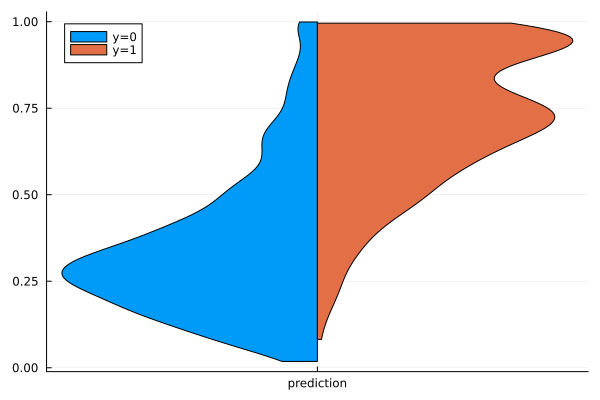

In [255]:
v1 = y_train_hat[[i==0 for i in y_train]]
v2 = y_train_hat[[i==1 for i in y_train]]
length(v1)
length(v2)
StatsPlots.violin(["prediction"], v1, label="y=0", side=:left)
StatsPlots.violin!(["prediction"], v2, label="y=1", side=:right)
StatsPlots.current()

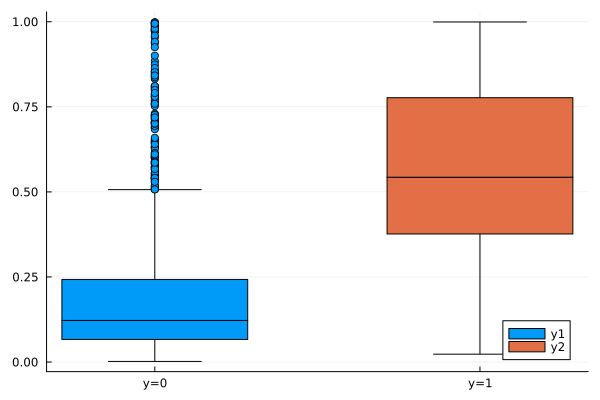

In [249]:
StatsPlots.boxplot(["y=0"], v1)
StatsPlots.boxplot!(["y=1"], v2)
StatsPlots.current()

acc:83.36439888164026
Thresh:0.566
acc:82.17522658610272
Thresh:0.59
acc (train thresh):0.8141993957703928


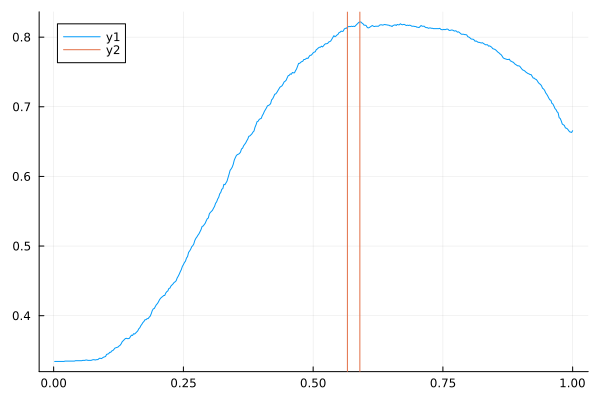

In [256]:
function acc(ytrue, yhat, thresh)
    mean(ytrue[i] == (yhat[i]>thresh ? 1 : 0) for i in 1:length(ytrue))
end
thesh = (1:500)./500
accs = [acc(y_train, y_train_hat, i) for i in thesh]
bestthresh = thesh[argmax(accs)]
trainThresh = bestthresh
println("acc:", maximum(accs)*100)
println("Thresh:", bestthresh)
plot(thesh, accs)
vline!([bestthresh])

thesh = (1:500)./500
accs = [acc(y_valid, y_valid_hat, i) for i in thesh]
bestthresh = thesh[argmax(accs)]
println("acc:", maximum(accs)*100)
println("Thresh:", bestthresh)
println("acc (train thresh):", acc(y_valid, y_valid_hat, trainThresh))
plot(thesh, accs)
vline!([bestthresh, trainThresh])


In [219]:
X_train_normalized = copy(X_train);
vars = var(X_train_normalized, dims=1)
means = mean(X_train_normalized, dims=1)
X_train_normalized = (X_train_normalized .- means) ./ vars;

In [229]:
# var(X_train_normalized, dims=1)
(X_train[5,2]-means[2])/vars[2]
# (0.13409961685823754 - 0.30760869314175465)/0.12881995487195644
# X_train_normalized[5,2]

-214.48951436059156

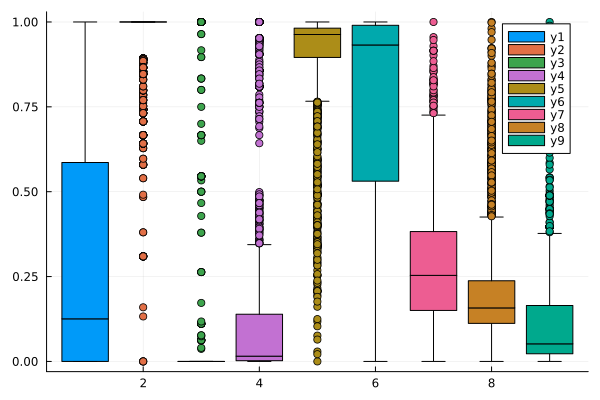

In [251]:
# StatsPlots.size(200, 200)
StatsPlots.boxplot([1], X_train[:,1])
for i in 2:size(X_train, 2)
    StatsPlots.boxplot!([i], X_train[:,i])
end
StatsPlots.current()

## **Validation Visualization**

In [387]:
fpr, tpr, thresholds = sklearn_metrics.roc_curve(y_valid, y_valid_hat);

plot(fpr, tpr)

LoadError: UndefVarError: sklearn_metrics not defined

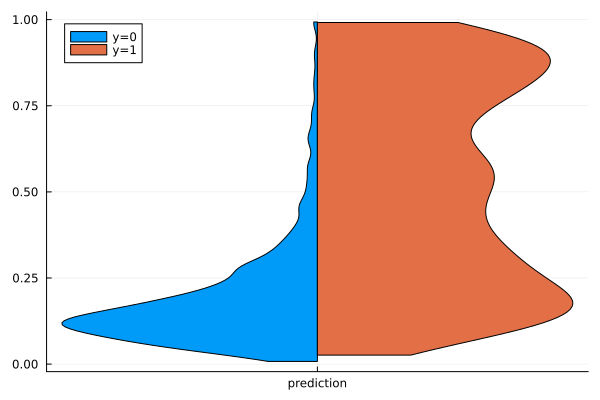

In [252]:
v1 = y_valid_hat[[i==0 for i in y_valid]]
v2 = y_valid_hat[[i==1 for i in y_valid]]
length(v1)
length(v2)
StatsPlots.violin(["prediction"], v1, label="y=0", side=:left)
StatsPlots.violin!(["prediction"], v2, label="y=1", side=:right)
StatsPlots.current()

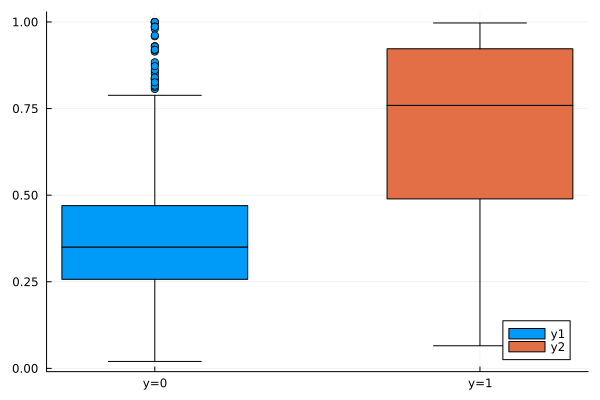

In [235]:
StatsPlots.boxplot(["y=0"], v1)
StatsPlots.boxplot!(["y=1"], v2)
StatsPlots.current()

76_15_1_finalpred
76_15_1_finalpred_VAL
21
21
[0.48373127970946705, 0.4699435055724494, 0.46626718862126465, 0.4477541235742383, 0.48150438879094615, 0.5992444880766166, 0.612047866271563, 0.47225974127898485, 0.32767391226273856, 0.31851374708574365, 0.3265940490903435, 0.3283012045998588, 0.3110163027617215, 0.38565832828855584, 0.4529918139988582, 0.35352669842632073, 0.34080908659834686, 0.3171736751494567, 0.3378235105170672]


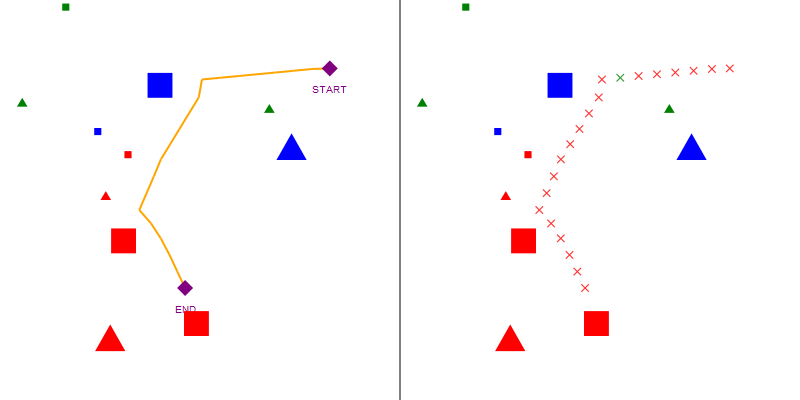

In [303]:
function draw_measurements_temp(scene, measurements, target_frame=luxor_frame(DEFAULT_IMAGE_WIDTH, DEFAULT_IMAGE_HEIGHT); markersize=8, color="black")
    convert = frame_converter(Frame(scene), target_frame)

    # Draw the measurements
    for measurement in measurements
        pos = convert(measurement)
        Luxor.setcolor(color)
        Luxor.setopacity(.8)
        Luxor.polycross(pos, markersize/1.5, 4, .15, pi/4, action=:fill)
        Luxor.setopacity(1)
    end
end


function viz_label(roomnum, tasknum, runno)
    label_key = string(tasknum)*"_"*string(runno)
    x = tasknum <= 40 ? "2" : "4"
    y = string((tasknum-1) % 40 + 1)
    file_name = "memory_"*x*".1."*y*".json"
    room = readdata_get_comm_game_path() * "/python_scripts/visualize/pairs_data/room0000"*roomnum
    dict1 = readdata_get_task_from_room(room, file_name, VERBOSE=false);
    
    playerdata1 = readdata_get_playerdata_from_task(dict1, 2*runno - 1, VERBOSE=false);
    playerdata2 = readdata_get_playerdata_from_task(dict1, 2*runno, VERBOSE=false);
    scene = utils_scene_from_playerdata(playerdata1, VERBOSE=false)
    
    if playerdata1["role"] == "STUDENT"  # Make player1 always teacher
        playerdata1, playerdata2 = playerdata2, playerdata1
    end
    player_trajectory1 = [Point(x, y) for (x, y) in zip(playerdata1["x"], playerdata1["y"])]
    player_trajectory2 = [Point(x, y) for (x, y) in zip(playerdata2["x"], playerdata2["y"])]
    
    trajectory = utils_strip_trajectory(player_trajectory1; epsilon=20)
    println(length(trajectory))
    
    visualize_grid(0:1, 2, 800; separators="gray") do i, frame
        if i == 0
            draw_path(scene, trajectory[1], trajectory[end], trajectory, frame; markersize=8, pathopacity=1)
            # draw_measurements(scene, trajectory, frame; markersize=8)
            draw_scene(scene, frame)
        elseif i == 1 && roomnum in keys(labels) && label_key in keys(labels[roomnum])
            println(length(trajectory))
            println(labels[roomnum][label_key])
            l = [(i<=length(labels[roomnum][label_key]) && labels[roomnum][label_key][i]>thresh ? 1 : 0) for i in 1:length(trajectory)]
            slice = [i for i in 1:length(trajectory) if l[i]==1]
            draw_measurements_temp(scene, trajectory[slice], frame; markersize=8, color="green")
            slice = [i for i in 1:length(trajectory) if l[i]==0]
            draw_measurements_temp(scene, trajectory[slice], frame; markersize=8, color="red")
            draw_scene(scene, frame)
        end
    end
end
#recheck 9 21 9

y_train_hat_dict = lr_format_out(training_rooms, training_results_list, training_labels_list, y_train_hat)
y_val_hat_dict = lr_format_out(validation_rooms, validation_results_list, validation_labels_list, y_valid_hat)
labels = y_val_hat_dict
thresh = 0.6

roomnum = "76"
# tasknum = 14
# tasknum += 1
runno = 6

# rm = 1
# t = 1
t = t+1

# roomnum = [i for i in keys(labels)][rm]
# v1 = [i for i in ]
v2 = [i for i in keys(labels[roomnum])][t]
tasknum, runno = split(v2, "_")

tasknum = parse(Int64, split(v2, "_")[1])
runno = parse(Int64, split(v2, "_")[2])
println(roomnum, "_", tasknum, "_", runno, "_finalpred")
println(roomnum, "_", tasknum, "_", runno, "_finalpred_VAL")


# labels[roomnum][string(tasknum)*"_"*string(runno)] = [i for i in 1:15]
# labels[roomnum][string(tasknum)*"_"*string(runno)] = [i for i in 24:44]
# labels[roomnum][string(tasknum)*"_"*string(runno)] = [i for i in [15:33;65:76]]
# labels[roomnum][string(tasknum)*"_"*string(runno)] = []
# delete!(labels[roomnum], string(tasknum)*"_"*string(runno))

viz_label(roomnum, tasknum, runno)
# readdata_visualize_memory(roomnum=roomnum, tasknum=tasknum, hide_student=true)
# y_train_hat_dict
# training_labels_list


In [75]:
labels[roomnum]

Dict{String, Dict{Any, Any}} with 3 entries:
  "81" => Dict("31_11"=>[0.273642, 0.324926, 0.311447, 0.278054, 0.37305, 0.364…
  "79" => Dict("33_1"=>[0.32816, 0.294913, 0.268342, 0.276586, 0.159437, 0.2922…
  "76" => Dict("16_1"=>[0.32816, 0.294913, 0.268342, 0.276586, 0.159437, 0.2922…

In [110]:
# 76 33
# 79 5
# 81 14
[k for (k,v) in validation_labels_list["81"]]

14-element Vector{String}:
 "8_1"
 "31_11"
 "2_7"
 "13_1"
 "2_5"
 "25_6"
 "9_1"
 "1_1"
 "7_1"
 "10_1"
 "1_3"
 "2_1"
 "11_1"
 "12_1"